# Remove duplicates

References:
-   code to download images from Steam: https://github.com/woctezuma/google-colab
-   image data stored on Google Drive: https://github.com/woctezuma/download-steam-banners-data

## Install

In [ ]:
%pip install google-colab-transfer imagededup

## Import data

In [ ]:
import colab_transfer

colab_transfer.mount_google_drive()

gd = colab_transfer.get_path_to_home_of_google_drive()
lm = colab_transfer.get_path_to_home_of_local_machine()

Mounted at /content/drive/


In [ ]:
file_name = 'original_steam_logos.tar.gz'

colab_transfer.copy_file(file_name,
                         source = gd + 'steam_logos/',
                         destination = lm)

Copying /content/drive/My Drive/steam_logos/original_steam_logos_640x360.tar.gz to /content/original_steam_logos_640x360.tar.gz


In [ ]:
%cd /content/

!echo tar -xf {file_name}
!tar -xf {file_name}

/content
tar -xf original_steam_logos_640x360.tar.gz


## Boilerplate functions

### Parsing utils

In [ ]:
from pathlib import Path

def get_app_id(file_name):
  app_id = Path(file_name).name.replace('.png', '')

  return app_id

In [ ]:
def get_url(file_name=None,
            app_id=None):
  if app_id is None:
    app_id = get_app_id(file_name)

  url = 'https://cdn.cloudflare.steamstatic.com/steam/apps/{}/logo.png'.format(app_id)

  return url

### Disk utils

In [ ]:
import glob
import os

def list_file_names(image_dir='original_steam_logos/',
                    file_ext='.png'):
  if not image_dir.endswith('/'):
    image_dir += '/'

  file_names = glob.glob(image_dir + '*' + file_ext)

  file_names = sorted(file_names, key=lambda f: os.path.getsize(f))

  return file_names

In [ ]:
def save_app_ids_to_file(output_file_name, 
                         image_dir = 'original_steam_logos/'):
  file_names = list_file_names(image_dir)

  app_ids = [
            str(get_app_id(f)) for f in file_names
  ]

  app_ids = sorted(app_ids, key=int)

  print('#appIDs = {}'.format(len(app_ids)))

  with open(output_file_name, 'w') as f:
    f.write('\n'.join(app_ids))

  return

### Display utils

In [ ]:
from scipy import stats
import os

import PIL

import cv2
from google.colab.patches import cv2_imshow

def show_image_for_percentile(file_sizes,
                              percentile,
                              use_white_transparency = False):
  print('Percentile: {}%'.format(percentile))
  assert(0 <= percentile < 100)

  score = stats.scoreatpercentile(file_sizes, percentile)
  print('File size: {} KB'.format(score/1000))

  f = next(i for i in file_names if os.path.getsize(i) > score)
  print('File name: {}'.format(f))

  print(get_url(f))

  if use_white_transparency:
    # Transparent is white
    img = PIL.Image.open(f)
    img
  else:
    # Transparent is black
    cv2_imshow(cv2.imread(f))

  return

## Remove blank images

In [ ]:
file_names = list_file_names()

len(file_names)

21281

### Identify

In [ ]:
from PIL import Image
import numpy as np

blank_image_names = []
image_names_if_decompressed_too_large = []

for f in file_names:
  img = Image.open(f)

  try:
    # Reference: https://stackoverflow.com/a/38749333    
    extrema = img.convert("L").getextrema()
  except ValueError:
    image_names_if_decompressed_too_large.append(f)
    continue

  if extrema[0] == extrema[1]:
    blank_image_names.append(f)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


### Display

['original_steam_logos/977880.png']
['original_steam_logos/664210.png']
Uniform image for original_steam_logos/977880.png


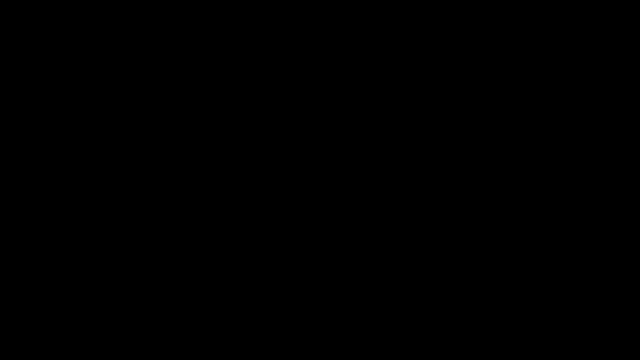

Decompressed data is too large for original_steam_logos/664210.png


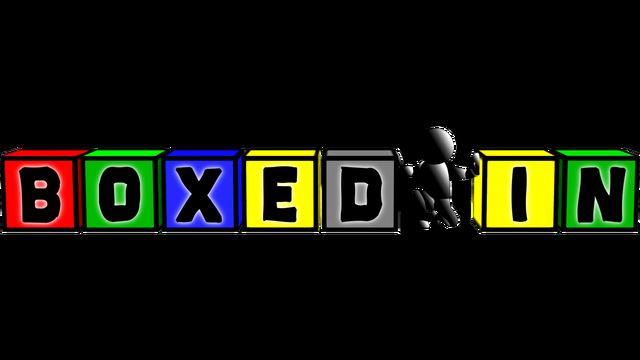

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

print(blank_image_names)
print(image_names_if_decompressed_too_large)

for f in blank_image_names:
  print('Uniform image for {}'.format(f))
  cv2_imshow(cv2.imread(f))

for f in image_names_if_decompressed_too_large:
  print('Decompressed data is too large for {}'.format(f))
  cv2_imshow(cv2.imread(f))

### Remove

In [ ]:
%cd /content/

/content


In [ ]:
import os

for f in blank_image_names:
  print('Removing {}'.format(f))
  os.remove(f)

for f in image_names_if_decompressed_too_large:
  print('Removing {}'.format(f))
  os.remove(f)

Removing original_steam_logos/977880.png
Removing original_steam_logos/664210.png


## Identify and remove images with an uncommon size (height, width)

### List all the images

In [ ]:
file_names = list_file_names()

len(file_names)

21279

### Build dictionaries

In [ ]:
from PIL import Image

d = dict() # appID -> image size
dd = dict() # image size -> list of appIDs

for f in file_names:
  app_id = get_app_id(f)

  try:
    img = Image.open(f)
  except ValueError:
    continue

  sz = img.size

  d[app_id] = sz
  
  try:
    dd[sz].append(app_id)
  except KeyError:
    dd[sz] = [app_id]

In [ ]:
dd_count = dict() # image size -> number of appIDs

for sz in dd:
  dd_count[sz] = len(dd[sz])

### Unique logo sizes

There are 1138 different logo sizes.

In [ ]:
num_uniques_sizes = len(dd)

print(num_uniques_sizes)

1138


### Describe stats

Most logos are 640x360 (ratio 1.78).

1) (640, 360) (ratio 1.78): 21740
https://cdn.cloudflare.steamstatic.com/steam/apps/1181750/logo.png


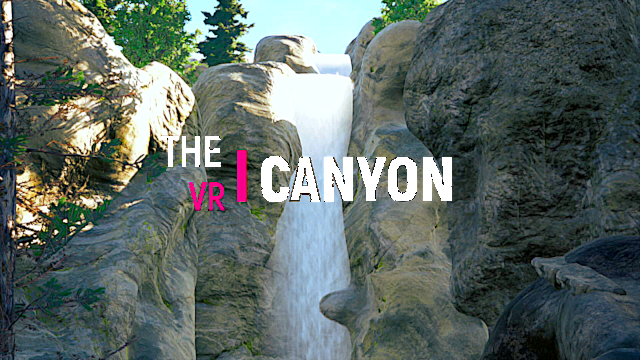

2) (640, 100) (ratio 6.40): 115
https://cdn.cloudflare.steamstatic.com/steam/apps/33570/logo.png


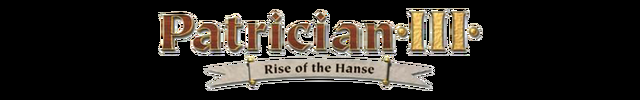

3) (360, 360) (ratio 1.00): 111
https://cdn.cloudflare.steamstatic.com/steam/apps/1033540/logo.png


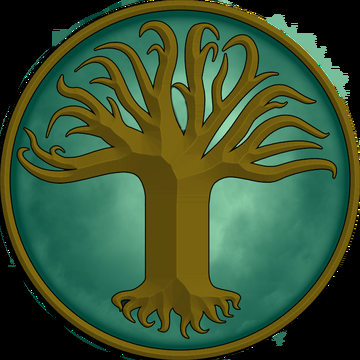

4) (640, 206) (ratio 3.11): 95
https://cdn.cloudflare.steamstatic.com/steam/apps/567220/logo.png


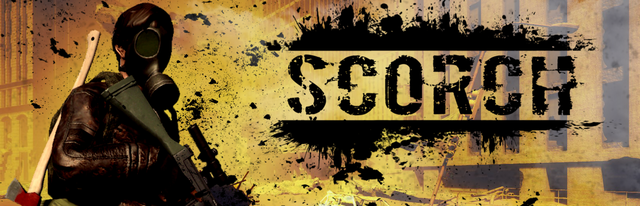

5) (640, 320) (ratio 2.00): 92
https://cdn.cloudflare.steamstatic.com/steam/apps/1091570/logo.png


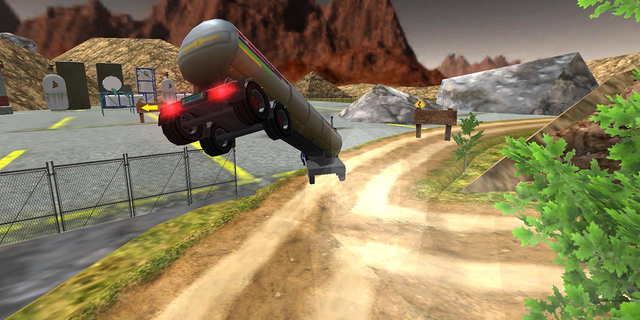

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

num_sz_to_display = 5
verbose = True
image_dir = '/content/original_steam_logos/'

l = sorted(dd_count.keys(), key=lambda x: dd_count[x], reverse=True)

for i, sz in enumerate(l[:num_sz_to_display]):
  ratio = sz[0]/sz[1]
  print('{}) {} (ratio {:.2f}): {}'.format(i+1, sz, ratio, dd_count[sz]))
  
  examplar_index = -1
  examplar_app_id = dd[sz][examplar_index]
  url = get_url(app_id=examplar_app_id)
  print(url)

  if verbose:
    examplar_file_name =  image_dir + str(examplar_app_id) + '.png' 
    cv2_imshow(cv2.imread(examplar_file_name))

In [ ]:
most_common_image_size = l[0]
images_with_most_common_size = dd[most_common_image_size]

len(images_with_most_common_size)

21279

### Remove every image of uncommon size, i.e. a size other than 640x360

In [ ]:
%cd /content/

In [ ]:
folder_common = 'original_steam_logos_640x360'
folder_other = 'original_steam_logos_other'

!mkdir -p {folder_common}
!mkdir -p {folder_other}

In [ ]:
import shutil

for f in file_names:
  app_id = get_app_id(f)

  if str(app_id) in images_with_most_common_size:
    output_folder = folder_common
  else:
    output_folder = folder_other

  output_file_name = output_folder + '/' + str(app_id) + '.png'
  shutil.move(f, output_file_name)

In [ ]:
save_app_ids_to_file('app_ids_with_logo_640x360.txt',
                     image_dir=folder_common)

#appIDs = 21734


In [ ]:
save_app_ids_to_file('app_ids_with_logo_other.txt',
                     image_dir=folder_other)

#appIDs = 4117


### Rename working folder

In [ ]:
# !rm -rf original_steam_logos
# !mv original_steam_logos_640x360 original_steam_logos

## Identify and remove duplicates

Reference: https://idealo.github.io/imagededup/user_guide/finding_duplicates/

In [ ]:
file_names = list_file_names()

len(file_names)

21279

### Encode

**Caveat**: if images are PNG, the `CNN` method of this library returns an error.

In [ ]:
from imagededup.methods import PHash

encoder = PHash()

In [ ]:
# image_dir = '/content/original_steam_logos/'

# Generate encodings for all images in an image directory
encodings = encoder.encode_images(image_dir=image_dir)

2020-09-25 17:47:21,646: INFO Start: Calculating hashes...
100%|██████████| 21279/21279 [02:34<00:00, 137.91it/s]
2020-09-25 17:49:56,029: INFO End: Calculating hashes!


### Find

In [ ]:
max_distance_threshold = 0
save_file_name = 'duplicates_{}.json'.format(max_distance_threshold)

# Find duplicates using the generated encodings
duplicates = encoder.find_duplicates(encoding_map=encodings,
                                     max_distance_threshold = max_distance_threshold,
                                     outfile = save_file_name)

files_with_duplicates = [f for f in duplicates.keys() if len(duplicates[f])>0]

files_with_duplicates = sorted(files_with_duplicates,
                               key=lambda x: len(duplicates[x]),
                               )

print('#files with at least one duplicate: {}'.format(len(files_with_duplicates)))

2020-09-25 13:42:36,284: INFO Start: Evaluating hamming distances for getting duplicates
2020-09-25 13:42:36,286: INFO Start: Retrieving duplicates using Cython Brute force algorithm
100%|██████████| 21733/21733 [00:05<00:00, 3748.69it/s]
2020-09-25 13:42:42,410: INFO End: Retrieving duplicates using Cython Brute force algorithm
2020-09-25 13:42:42,411: INFO End: Evaluating hamming distances for getting duplicates
2020-09-25 13:42:42,462: INFO Start: Saving duplicates as json!
2020-09-25 13:42:42,815: INFO End: Saving duplicates as json!


#files with at least one duplicate: 542


In [ ]:
file_names_of_duplicates = encoder.find_duplicates_to_remove(
    encoding_map=encodings,
    max_distance_threshold = max_distance_threshold,
    )

print('#files to be removed: {}'.format(len(file_names_of_duplicates)))

2020-09-25 13:42:42,872: INFO Start: Evaluating hamming distances for getting duplicates
2020-09-25 13:42:42,874: INFO Start: Retrieving duplicates using Cython Brute force algorithm
100%|██████████| 21733/21733 [00:05<00:00, 3988.67it/s]
2020-09-25 13:42:48,816: INFO End: Retrieving duplicates using Cython Brute force algorithm
2020-09-25 13:42:48,818: INFO End: Evaluating hamming distances for getting duplicates


#files to be removed: 453


### Display

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (15, 10)

#duplicates = 2 for appID = 1222860.png (https://cdn.cloudflare.steamstatic.com/steam/apps/1222860/logo.png)


/usr/local/lib/python3.6/dist-packages/imagededup/utils/plotter.py:66: UserWarning: tight_layout: falling back to Agg renderer
  gs.tight_layout(fig)


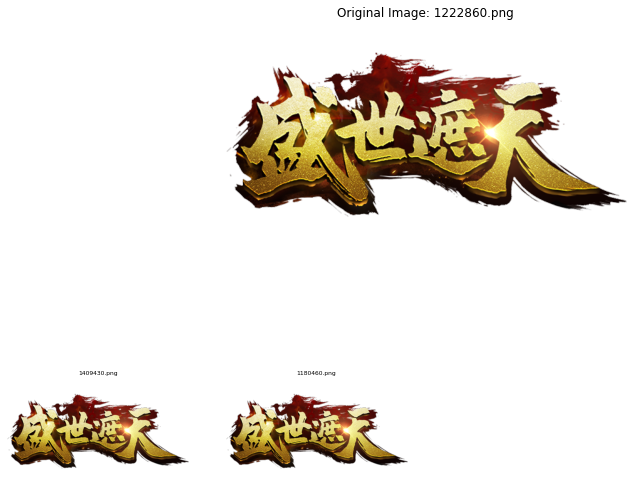

https://cdn.cloudflare.steamstatic.com/steam/apps/1222860/logo.png
https://cdn.cloudflare.steamstatic.com/steam/apps/1409430/logo.png
https://cdn.cloudflare.steamstatic.com/steam/apps/1180460/logo.png


In [ ]:
from imagededup.utils import plot_duplicates

test_file_name_index = 150
test_file_name = files_with_duplicates[test_file_name_index]

num_duplicates = len(duplicates[test_file_name])

print('#duplicates = {} for appID = {} ({})'.format(
    num_duplicates,
    test_file_name,
    get_url(test_file_name),
    ))

threshold = 20
if num_duplicates <= threshold:
  plot_duplicates(image_dir=image_dir,
                  duplicate_map=duplicates,
                  filename=test_file_name)
  
  print(get_url(test_file_name))
  for f in duplicates[test_file_name]:
    print(get_url(f))
else:
  print('Too many duplicates ({} > {}).'.format(num_duplicates, threshold))

### Remove duplicate files

In [ ]:
%cd /content/

In [ ]:
import os

for f in file_names_of_duplicates:
  os.remove(image_dir + f)

In [ ]:
save_app_ids_to_file('app_ids_with_logo_640x360_no_duplicate.txt')

#appIDs = 21281


In [ ]:
!du -sh original_steam_logos/

2.2G	original_steam_logos_png/


## Identify tiny or large files (in KB)

Tiny or large files are **not** removed for now.

In [ ]:
file_names = list_file_names()

len(file_names)

21279

In [ ]:
from scipy import stats
import os

file_sizes = [os.path.getsize(f) for f in file_names]

summary = stats.describe(file_sizes)
print(summary)

DescribeResult(nobs=21279, minmax=(470, 1380627), mean=104281.94294844683, variance=7833964904.924276, skewness=2.035461924911261, kurtosis=11.847128984272695)


### Display histogram

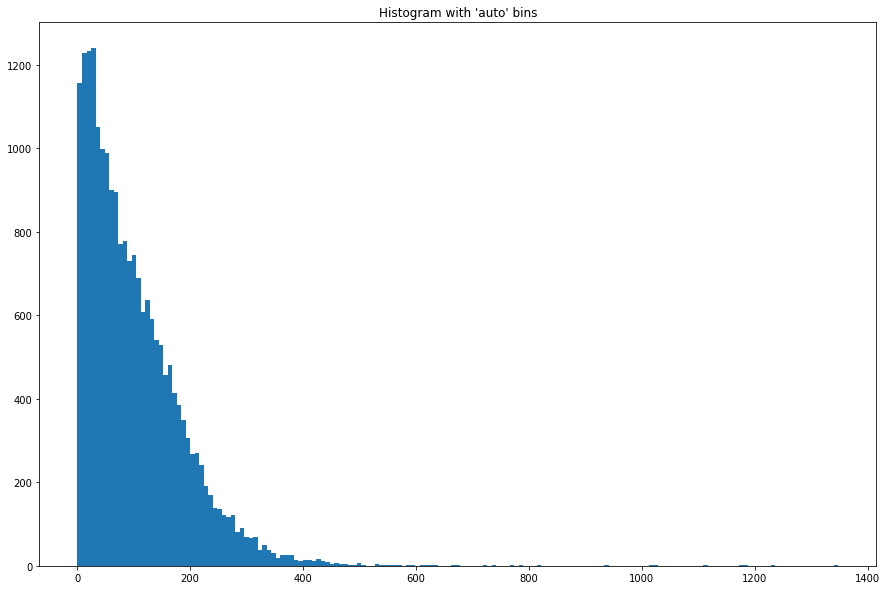

In [ ]:
import matplotlib.pyplot as plt

file_sizes_in_kb = [i/1024 for i in file_sizes]

_ = plt.hist(file_sizes_in_kb, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

### Display images for each percentile

Percentile: 0%
File size: 0.47 KB
File name: original_steam_logos/941640.png
https://cdn.cloudflare.steamstatic.com/steam/apps/941640/logo.png


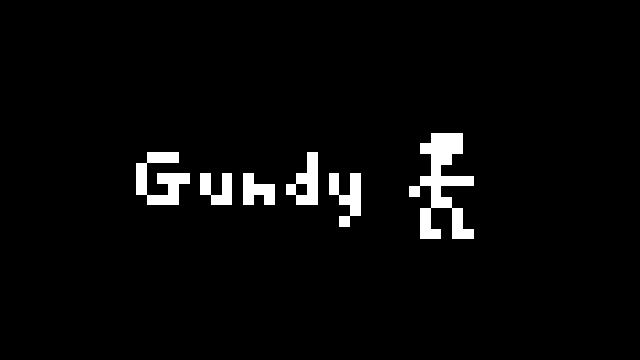

Percentile: 5%
File size: 7.823 KB
File name: original_steam_logos/1357220.png
https://cdn.cloudflare.steamstatic.com/steam/apps/1357220/logo.png


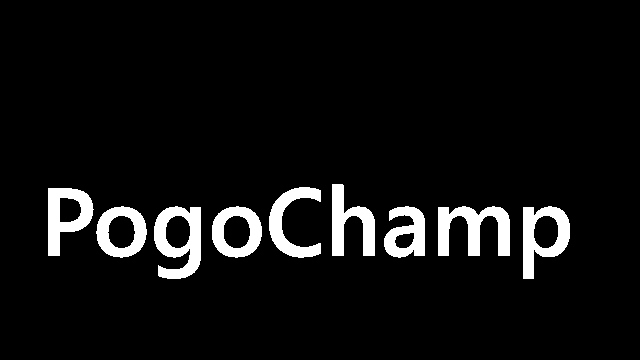

Percentile: 10%
File size: 15.035 KB
File name: original_steam_logos/680830.png
https://cdn.cloudflare.steamstatic.com/steam/apps/680830/logo.png


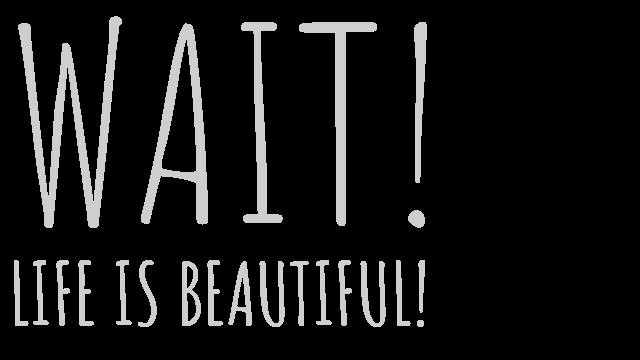

Percentile: 15%
File size: 22.069599999999998 KB
File name: original_steam_logos/1378230.png
https://cdn.cloudflare.steamstatic.com/steam/apps/1378230/logo.png


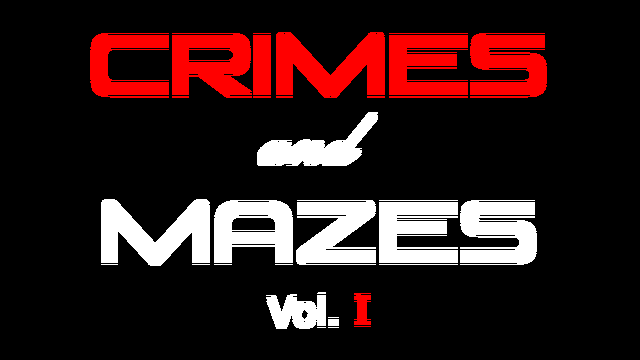

Percentile: 20%
File size: 29.128 KB
File name: original_steam_logos/1136100.png
https://cdn.cloudflare.steamstatic.com/steam/apps/1136100/logo.png


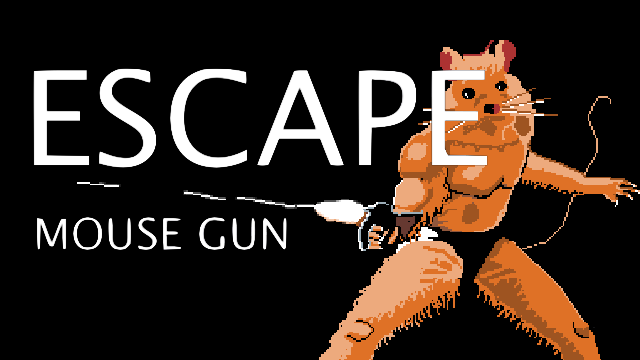

Percentile: 25%
File size: 36.6315 KB
File name: original_steam_logos/538030.png
https://cdn.cloudflare.steamstatic.com/steam/apps/538030/logo.png


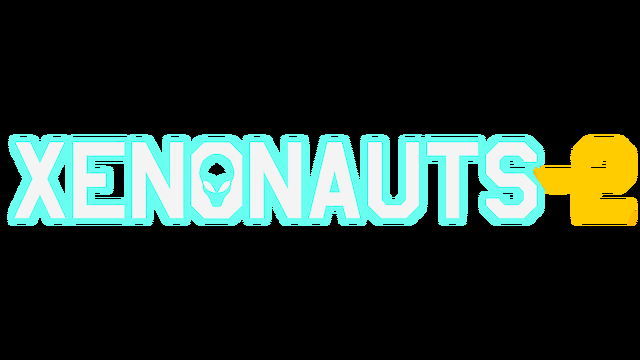

Percentile: 30%
File size: 45.09419999999999 KB
File name: original_steam_logos/820240.png
https://cdn.cloudflare.steamstatic.com/steam/apps/820240/logo.png


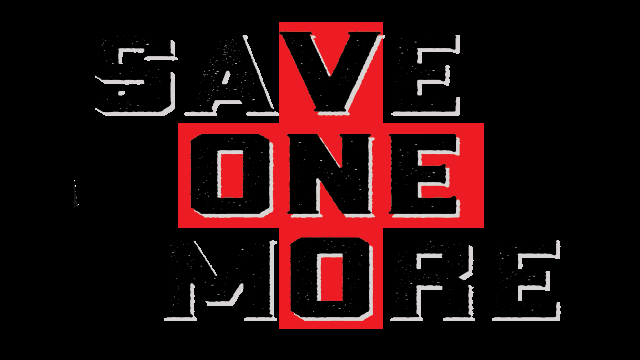

Percentile: 35%
File size: 54.009899999999995 KB
File name: original_steam_logos/1121550.png
https://cdn.cloudflare.steamstatic.com/steam/apps/1121550/logo.png


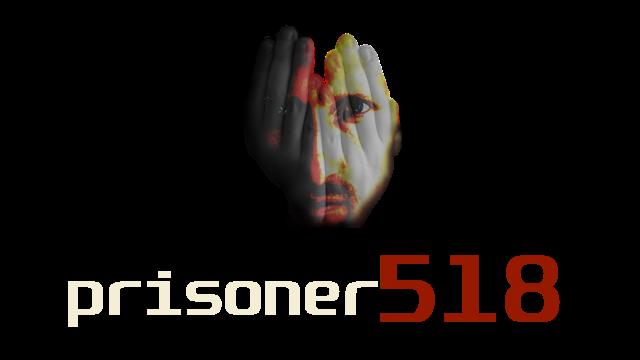

Percentile: 40%
File size: 63.27360000000001 KB
File name: original_steam_logos/1358560.png
https://cdn.cloudflare.steamstatic.com/steam/apps/1358560/logo.png


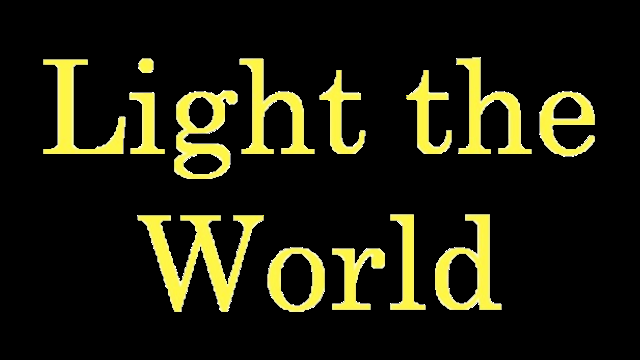

Percentile: 45%
File size: 72.99839999999999 KB
File name: original_steam_logos/1262790.png
https://cdn.cloudflare.steamstatic.com/steam/apps/1262790/logo.png


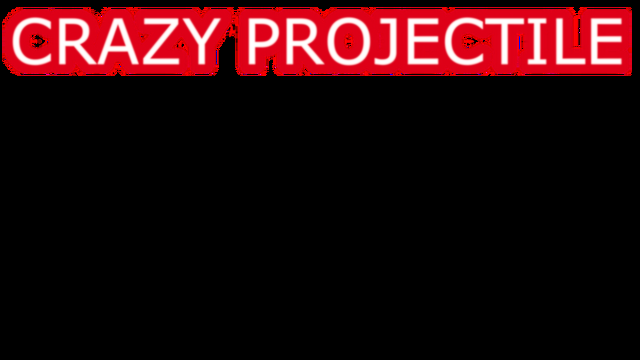

Percentile: 50%
File size: 84.137 KB
File name: original_steam_logos/578650.png
https://cdn.cloudflare.steamstatic.com/steam/apps/578650/logo.png


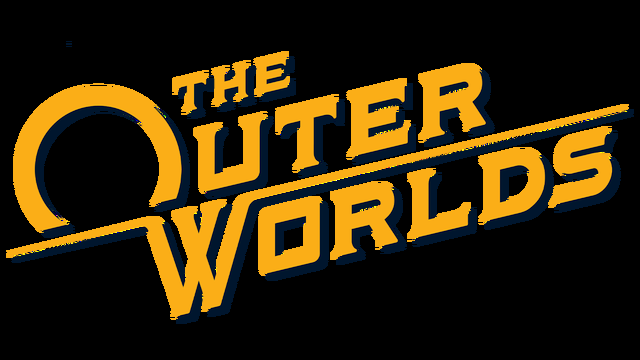

Percentile: 55%
File size: 95.43120000000002 KB
File name: original_steam_logos/1184980.png
https://cdn.cloudflare.steamstatic.com/steam/apps/1184980/logo.png


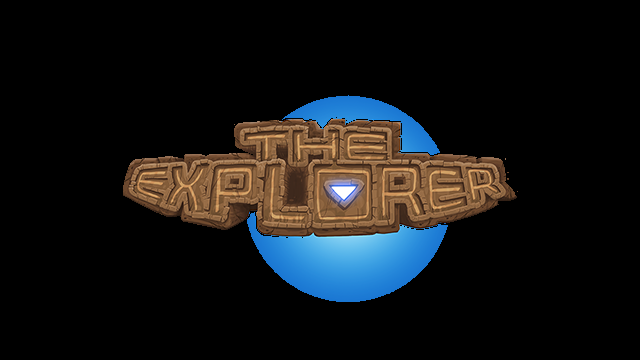

Percentile: 60%
File size: 107.2768 KB
File name: original_steam_logos/694680.png
https://cdn.cloudflare.steamstatic.com/steam/apps/694680/logo.png


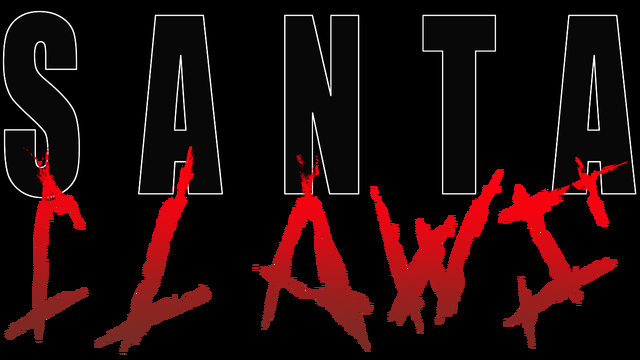

Percentile: 65%
File size: 120.40520000000001 KB
File name: original_steam_logos/1267830.png
https://cdn.cloudflare.steamstatic.com/steam/apps/1267830/logo.png


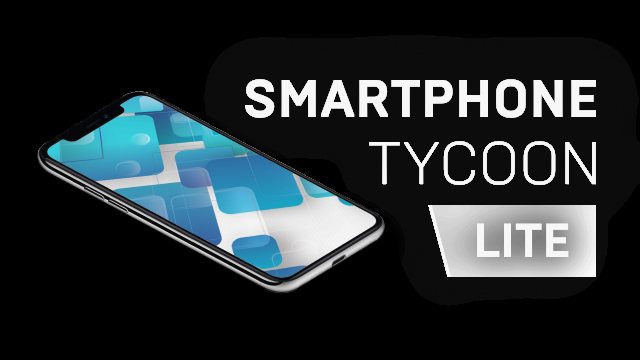

Percentile: 70%
File size: 134.4504 KB
File name: original_steam_logos/1289060.png
https://cdn.cloudflare.steamstatic.com/steam/apps/1289060/logo.png


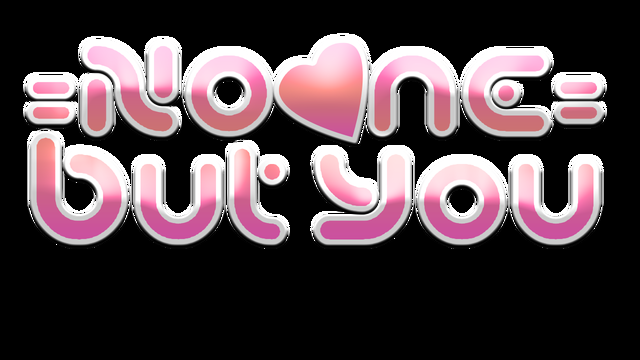

Percentile: 75%
File size: 149.971 KB
File name: original_steam_logos/791260.png
https://cdn.cloudflare.steamstatic.com/steam/apps/791260/logo.png


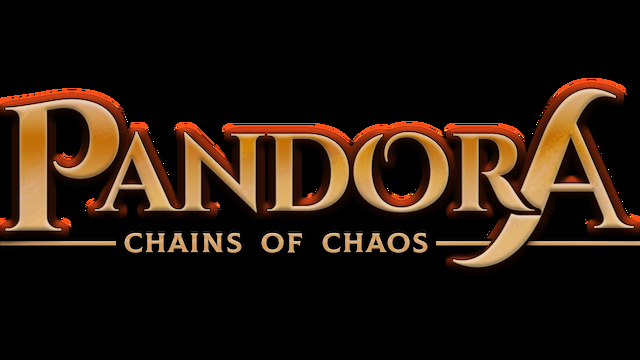

Percentile: 80%
File size: 168.37440000000004 KB
File name: original_steam_logos/1233040.png
https://cdn.cloudflare.steamstatic.com/steam/apps/1233040/logo.png


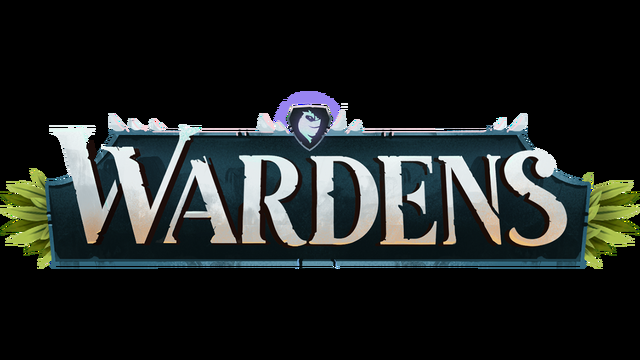

Percentile: 85%
File size: 189.20759999999993 KB
File name: original_steam_logos/221100.png
https://cdn.cloudflare.steamstatic.com/steam/apps/221100/logo.png


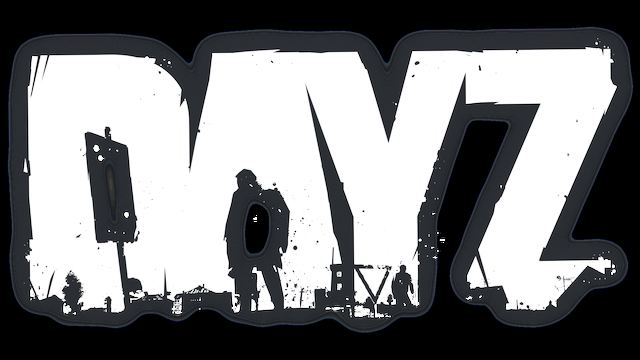

Percentile: 90%
File size: 217.97979999999998 KB
File name: original_steam_logos/1371480.png
https://cdn.cloudflare.steamstatic.com/steam/apps/1371480/logo.png


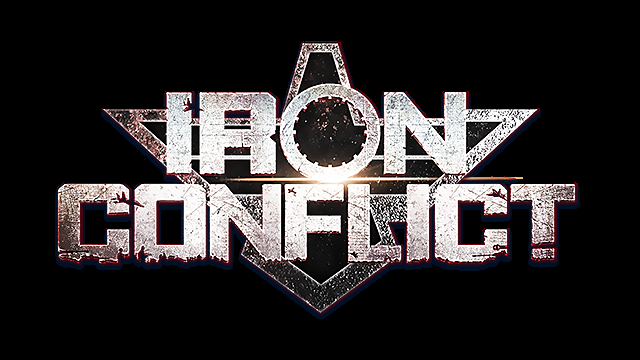

Percentile: 95%
File size: 268.2095999999999 KB
File name: original_steam_logos/411320.png
https://cdn.cloudflare.steamstatic.com/steam/apps/411320/logo.png


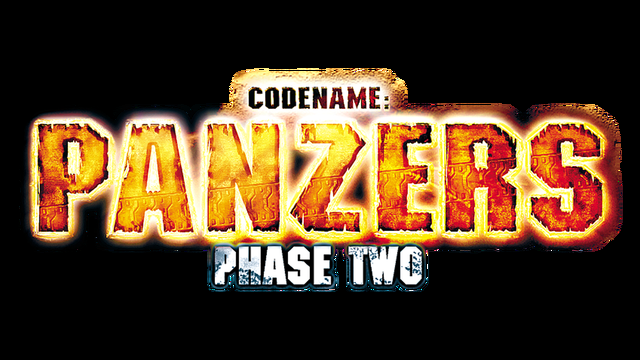

In [ ]:
for percentile in range(0, 100, 5):
  show_image_for_percentile(file_sizes, percentile)

## Summary about file removal

### Remove blank images

We have removed blank and faulty images.

In [ ]:
len(blank_image_names)

In [ ]:
len(image_names_if_decompressed_too_large)

### Remove images with uncommon size

We have kept the 640x360 images.

In [ ]:
len(images_with_most_common_size)

21734

### Remove duplicate files

Then, we have removed the following files.

In [ ]:
len(file_names_of_duplicates)

453

### Information about tiny and large files (in KB)

Tiny or large files are **not** removed for now.

In [ ]:
min_size = stats.scoreatpercentile(file_sizes, per=0.1)
print('{:.2f} KB'.format(min_size/1024))

0.61 KB


In [ ]:
max_size = stats.scoreatpercentile(file_sizes, per=99.9)
print('{:.2f} KB'.format(max_size/1024))

628.89 KB


In [ ]:
file_names_with_uncommon_file_size = [
                                      f for f in file_names
                                      if os.path.getsize(f) < min_size or os.path.getsize(f) > max_size
]

In [ ]:
len(file_names_with_uncommon_file_size)

44